# validate results

## TODO
what happened to tracing when I fixed probability calcs - it seems like all trip ids are attached when I add one by
hand below - why?

In [1]:
import numba
%load_ext autoreload

In [2]:
%autoreload 2

In [231]:
import os
import argparse
from datetime import datetime

import numpy as np
import pandas as pd
from numpy.random import default_rng
from statsmodels.stats.gof import powerdiscrepancy
from statsmodels.stats.proportion import multinomial_proportions_confint
import numba

from activitysim.cli import run
from activitysim.core import inject

from fru_utils import run_trip_mode_choice, comp_mode_shares, mode_choice_for_trip

In [4]:
pd.set_option("max_columns", 500)

In [5]:
root_dir = "/mnt/c/Users/jan.zill/code/activitysim"
example_dir = os.path.join(root_dir, "test_example_mtc")

In [6]:
os.chdir(example_dir)

In [7]:
parser = argparse.ArgumentParser()
run.add_run_args(parser)
# args = parser.parse_args()
# parser.parse_args(['--sum', '7', '-1', '42'])
args = parser.parse_args(['-c', 'configs', '-o', 'output', '-d', 'data'])
#run.run(args)  # 2mins full example run
if not inject.is_injectable('preload_injectables'):
    from activitysim import abm  # register abm steps and other abm-specific injectables
run.handle_standard_args(args)  # possibly update injectables

In [8]:
## need to do this before loading checkpoint tables
#trace_hh_ids = 1024353
##1024353 has trip id 642446345 (at least) where logsum and probs are different
##2821179  # has trip_ids 2464104881 and 2464104885
#inject.add_injectable("trace_hh_id", trace_hh_ids)

In [9]:
%%time
trips_df_ru = run_trip_mode_choice()
trips_df = run_trip_mode_choice(choose_individual_max_utility=False)

setting trace_hh_id is wrong type, should be an int, but was <class 'list'>
estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'atwork' (27 trips)
trip_mode_choice tour_type 'eatout' (33 trips)
trip_mode_choice tour_type 'escort' (6 trips)
trip_mode_choice tour_type 'othdiscr' (43 trips)
trip_mode_choice tour_type 'othmaint' (46 trips)
trip_mode_choice tour_type 'school' (37 trips)
trip_mode_choice tour_type 'shopping' (77 trips)
trip_mode_choice tour_type 'social' (19 trips)
trip_mode_choice tour_type 'univ' (26 trips)
trip_mode_choice tour_type 'work' (168 trips)
Done
Running with %d trips 482


estimation bundle trip_mode_choice not in settings file estimation.yaml


trip_mode_choice tour_type 'atwork' (27 trips)
trip_mode_choice tour_type 'eatout' (33 trips)
trip_mode_choice tour_type 'escort' (6 trips)
trip_mode_choice tour_type 'othdiscr' (43 trips)
trip_mode_choice tour_type 'othmaint' (46 trips)
trip_mode_choice tour_type 'school' (37 trips)
trip_mode_choice tour_type 'shopping' (77 trips)
trip_mode_choice tour_type 'social' (19 trips)
trip_mode_choice tour_type 'univ' (26 trips)
trip_mode_choice tour_type 'work' (168 trips)
Done
CPU times: user 18.3 s, sys: 2.3 s, total: 20.6 s
Wall time: 17.8 s


In [10]:
c_ = ["trip_mode", "mode_choice_logsum"]
trips = trips_df_ru[c_].merge(trips_df[c_], left_index=True, right_index=True, how="outer", suffixes=["_fru", "_asim"])
pd.merge(trips_df_ru.trip_mode.value_counts(), trips_df.trip_mode.value_counts(), left_index=True, right_index=True,
         suffixes=["_fru", "_asim"])

,trip_mode_fru,trip_mode_asim
WALK,309,304
WALK_LOC,85,85
WALK_LRF,55,53
BIKE,15,17
TNC_SINGLE,7,4
DRIVEALONEFREE,5,4
SHARED2FREE,3,4
SHARED3FREE,2,1
WALK_HVY,1,4


In [11]:
if np.allclose(trips.mode_choice_logsum_fru, trips.mode_choice_logsum_asim):
    print("Logsums agree")
else:
    ((trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) / trips.mode_choice_logsum_fru).hist(bins=50)

Logsums agree


In [12]:
x_ = np.abs((trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim)).values
print(f"{x_.max():e}")

0.000000e+00


In [13]:
#ls_ = np.abs(((trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) / trips.mode_choice_logsum_fru))
#ls_.sort_values(ascending=False)
#trips.loc[trips.index == 642446345]
#trips.loc[np.abs(trips.mode_choice_logsum_fru - trips.mode_choice_logsum_asim) > 0]

# Run MC validation

see logit._each_nest parent_nest_scale for leaf node, and simulate.compute_nested_utilities for discussion of scales
of alternatives

easiest way is to run a simulation

In [14]:
from fru_utils import get_stuff
t, ru, neu, nu, ns, nested_probs, base_probs = get_stuff()  #do_these_purposes=["social"])  #social
bp = pd.concat(base_probs)

estimation bundle trip_mode_choice not in settings file estimation.yaml


Running with %d trips 482
trip_mode_choice tour_type 'atwork' (27 trips)
trip_mode_choice tour_type 'eatout' (33 trips)
trip_mode_choice tour_type 'escort' (6 trips)
trip_mode_choice tour_type 'othdiscr' (43 trips)
trip_mode_choice tour_type 'othmaint' (46 trips)
trip_mode_choice tour_type 'school' (37 trips)
trip_mode_choice tour_type 'shopping' (77 trips)
trip_mode_choice tour_type 'social' (19 trips)
trip_mode_choice tour_type 'univ' (26 trips)
trip_mode_choice tour_type 'work' (168 trips)
Done


In [107]:
%%time
#prun

num_samples = 10000
trip_id_to_check = 642446345  # 1e5 takes about 25s EDIT: BEFORE APPLY, now it's more like 65s and 1e4 takes 8s
#  work 615236801  also in trace log
#  social 2464104885 642446345 1767182945


#bp = base_probs[7]   # 7 for social, 9 for work. Check t[t.index == trip_id_to_check] to see which purpose, and
# output above to see which index
# choose_individual_max_utility = False
#ms_comp = comp_mode_shares(bp, choose_individual_max_utility, num_samples, trip_id_to_check)
#display(ms_comp.loc[((ms_comp.mode_share_obs != 0) | (ms_comp.trip_mode != 0)), ["mode_share_obs", "trip_mode"]].T)

choose_individual_max_utility = True
t_, c_, _ = mode_choice_for_trip(choose_individual_max_utility=choose_individual_max_utility,
                                 trip_id_to_check=trip_id_to_check, num_samples=num_samples)
sim_mode_shares = c_.trip_mode.value_counts() / c_.shape[0]
ms_comp = comp_mode_shares(bp, sim_mode_shares, trip_id_to_check)
#display(ms_comp.loc[((ms_comp.mode_share_obs != 0) | (ms_comp.trip_mode != 0)), ["mode_share_obs", "trip_mode"]].T)

estimation bundle trip_mode_choice not in settings file estimation.yaml


trip_mode_choice tour_type 'social' (10000 trips)
Done
CPU times: user 8.39 s, sys: 453 ms, total: 8.84 s
Wall time: 9.28 s


In [64]:
# Note power tests will be inf when expected count is zero (any non-zero count will be impossible)
eps = 0 #1e-14
non_zero_shares = ms_comp.loc[(ms_comp.mode_share_obs > eps) & (ms_comp.trip_mode > eps)][["mode_share_obs", "trip_mode"]]
ddof = non_zero_shares.shape[0] - 1  # what to use here? num alternatives - 1? What about zero expected count?

non_zero_shares.trip_mode *= num_samples

sum_ms = non_zero_shares.mode_share_obs.sum()
if sum_ms != 1.0:
    if np.abs(1.0 - sum_ms) > 1e-1:
        print(f"NOT GOOD {sum_ms} should be one")
        #print(f"sum ms is not one but {sum_ms}, re-normalising")
    non_zero_shares.mode_share_obs /= sum_ms

powerdiscrepancy(non_zero_shares.trip_mode.values, non_zero_shares.mode_share_obs.values, lambd=0, ddof=ddof)

(0.3439655414093617, nan)

In [99]:
from statsmodels.stats.proportion import multinomial_proportions_confint
ci = multinomial_proportions_confint(non_zero_shares.trip_mode.values, alpha=0.999, method='goodman')
vals = non_zero_shares.trip_mode.values / num_samples
np.hstack((ci, vals.reshape((len(vals),1))))

array([[4.17345080e-03, 5.98926219e-03, 5.00000000e-03],
       [1.45406892e-04, 6.18851051e-04, 3.00000000e-04],
       [4.13473933e-02, 4.66025328e-02, 4.39000000e-02],
       [5.64412252e-02, 6.25036058e-02, 5.94000000e-02],
       [8.87346329e-01, 8.95325012e-01, 8.91400000e-01]])

In [106]:
import numba

@numba.jit
def within(lower, upper, x):
    return (x >= lower) & (x <= upper)

@numba.jit
def numpy_within(x):
    lower = x[0]
    upper = x[1]
    val = x[2]
    return within(lower, upper, val)

test = np.hstack((ci, vals.reshape((len(vals),1))))
np.apply_along_axis(numpy_within, 1, test)

array([ True,  True,  True,  True,  True])

# All trips for paper


In [ ]:
%%time

num_samples = 10000 #about 8.5s per 10k per trip, so about 70mins for 10k sample. 1e5 is about 10 times as long, so
# about 11.5h

trips_to_check = bp.index.values #[100:103]

res = []

for trip_id_to_check in trips_to_check:
    _, c_, _ = mode_choice_for_trip(choose_individual_max_utility=True,
                            trip_id_to_check=trip_id_to_check, num_samples=num_samples)
    sim_mode_shares = c_.trip_mode.value_counts() / c_.shape[0]
    res.append(sim_mode_shares.rename(trip_id_to_check).to_frame().T)

result_sim = pd.concat(res).fillna(0)
result_sim.to_csv("temp_res_sim_10ksamples.csv")

In [158]:
#result_sim.merge(bp, left_index=True, right_index=True, how="outer", suffixes=["_sim", "_asim"]).fillna(0)

In [155]:
merged_results = result_sim.reset_index().rename(columns={"index": "trip_id"}).melt(id_vars=["trip_id"]).merge(
    bp.reset_index().rename(columns={"index": "trip_id"}).melt(id_vars=["trip_id"]),
    on=["trip_id", "variable"],
    how="outer",
    suffixes=["_sim", "_obs"]
).fillna(0)

<AxesSubplot:xlabel='value_sim', ylabel='value_obs'>

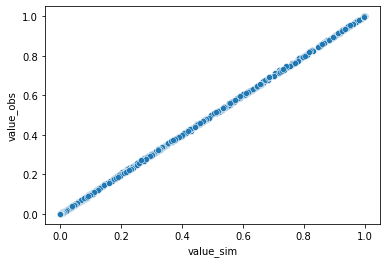

In [157]:
import seaborn as sns

sns.scatterplot(data=merged_results, x="value_sim", y="value_obs")

In [159]:
#from scipy.special import rel_entr
from scipy.stats import linregress
linregress(merged_results.value_sim.values, merged_results.value_obs.values)

LinregressResult(slope=0.999889299809943, intercept=5.271437621759412e-06, rvalue=0.9999938263765986, pvalue=0.0, stderr=3.49259911845371e-05, intercept_stderr=6.896656958760079e-06)

#### generic power discrepancy implementation in statsmodels

lambd{float, str}
float : exponent a for power discrepancy

‘loglikeratio’: a = 0

‘freeman_tukey’: a = -0.5

‘pearson’: a = 1 (standard chisquare test statistic)

‘modified_loglikeratio’: a = -1

‘cressie_read’: a = 2/3

‘neyman’ : a = -2 (Neyman-modified chisquare, reference from a book?)

note - they are all based on continuous approximations (x^2) so technically they might be inadequate for very small
occurences of counts

In [64]:
# Note power tests will be inf when expected count is zero (any non-zero count will be impossible)
eps = 0 #1e-14
non_zero_shares = ms_comp.loc[(ms_comp.mode_share_obs > eps) & (ms_comp.trip_mode > eps)][["mode_share_obs", "trip_mode"]]
ddof = non_zero_shares.shape[0] - 1  # what to use here? num alternatives - 1? What about zero expected count?

non_zero_shares.trip_mode *= num_samples

sum_ms = non_zero_shares.mode_share_obs.sum()
if sum_ms != 1.0:
    if np.abs(1.0 - sum_ms) > 1e-1:
        print(f"NOT GOOD {sum_ms} should be one")
        #print(f"sum ms is not one but {sum_ms}, re-normalising")
    non_zero_shares.mode_share_obs /= sum_ms

powerdiscrepancy(non_zero_shares.trip_mode.values, non_zero_shares.mode_share_obs.values, lambd=0, ddof=ddof)

(0.3439655414093617, nan)

array([[4.17345080e-03, 5.98926219e-03, 5.00000000e-03],
       [1.45406892e-04, 6.18851051e-04, 3.00000000e-04],
       [4.13473933e-02, 4.66025328e-02, 4.39000000e-02],
       [5.64412252e-02, 6.25036058e-02, 5.94000000e-02],
       [8.87346329e-01, 8.95325012e-01, 8.91400000e-01]])

array([ True,  True,  True,  True,  True])

In [230]:
# test_trip_res = merged_results.loc[merged_results.trip_id == 1045822217]
# ci = multinomial_proportions_confint(num_samples * test_trip_res.value_sim.values, alpha=0.999, method='goodman')
# np.hstack((test_trip_res[['value_obs']].to_numpy(), ci))

In [275]:
@numba.jit
def within(lower, upper, x):
    return (x >= lower) & (x <= upper)

@numba.jit
def numpy_within(x):
    lower = x[0]
    upper = x[1]
    val = x[2]
    return within(lower, upper, val)

def all_within_ci(trip_df, num_samples):
    ci = multinomial_proportions_confint(num_samples * trip_df.value_sim.values, alpha=0.99999, method='goodman')
    vals_with_ci = np.hstack((ci, trip_df[['value_obs']].to_numpy()))
    return np.apply_along_axis(numpy_within, 1, vals_with_ci).all()

In [276]:
vals_within_ci = merged_results.groupby("trip_id").apply(lambda group: all_within_ci(group, num_samples))

In [277]:
trips_not_within = vals_within_ci.loc[~vals_within_ci]
print(f"Have {trips_not_within.shape[0]} with contribution outside 0.99 CI")

Have 57 with contribution outside 0.99 CI


In [291]:
bad_res = []

for bad_trip_id in trips_not_within.index.values:
    trip_df = merged_results.loc[merged_results.trip_id == bad_trip_id]
    ci = multinomial_proportions_confint(num_samples * trip_df.value_sim.values, alpha=0.999, method='goodman')
    vals_with_ci = np.hstack((ci, trip_df[['value_obs']].to_numpy()))
    x_ = pd.DataFrame(vals_with_ci)
    x_['in_range'] = np.apply_along_axis(numpy_within, 1, vals_with_ci)[:np.newaxis]
    bad_res.append(x_.loc[~x_.in_range])
bad_res = pd.concat(bad_res)
bad_res.columns = ["lb", "ub", "value", "within"]

In [292]:
bad_res

,lb,ub,value,within
8,0.001687,0.003703,0.001667,False
8,0.005178,0.008409,0.004877,False
8,0.005531,0.008856,0.004911,False
3,0.000054,0.000738,0.000051,False
8,0.004739,0.007848,0.004560,False
3,0.000154,0.001038,0.000112,False
3,0.000154,0.001038,0.000125,False
3,0.000403,0.001589,0.000400,False
3,0.100737,0.112972,0.100614,False
3,0.000540,0.001852,0.000525,False


# Dev corner

## try to improve runtime of apply



In [239]:
nest_spec = ns[7]  # 7 is social
nest_util = nu[7].loc[nu[7].index == trip_id_to_check]

n = 10000

nest_util = nest_util.loc[nest_util.index.repeat(n)]
nest_util.index += np.arange(n)

display(base_probs[7].loc[base_probs[7].index == trip_id_to_check])

,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED
trip_id,,,,,,,,,,,,,,,,,,,,,
642446345,0.0,0.0,0.004883,0.0,4.701403e-14,0.0,0.044905,0.0,0.059962,0.889736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000096,0.000131,0.000287


In [240]:
%%time

from numpy.random import default_rng
from activitysim.core import logit

rng = default_rng(999)

def random_for_df(df):
    return rng.random(size=df.shape)

def add_ev1_random(df):
    uniform_rands = random_for_df(df)
    df = df + logit.inverse_ev1_cdf(uniform_rands)
    return df

nest_utils_for_choice = add_ev1_random(nest_util)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 21.1 ms


In [241]:
def group_nests_by_name(nest_spec):
    # group nests by level, returns {level: [nest.name at that level]}
    depth = np.max([x.level for x in logit.each_nest(nest_spec)])
    nest_levels = {x: [] for x in range(1, depth+1)}
    for n in logit.each_nest(nest_spec):
        nest_levels[n.level].append(n.name)
    return nest_levels

def make_choices_apply(nested_utilities, all_alternatives, logit_nest_groups, nest_alternatives_by_name):
    for level, nest_names in logit_nest_groups.items():
        if level == 1:
            next_level_alts = nest_alternatives_by_name[nest_names[0]]
            continue
        choice_this_level = nested_utilities[nested_utilities.index.isin(next_level_alts)].idxmax()
        if choice_this_level in all_alternatives:
            return choice_this_level
        next_level_alts = nest_alternatives_by_name[choice_this_level]
    raise ValueError("This should never happen - no alternative found")

In [242]:
%%prun
all_alternatives = set(nest.name for nest in logit.each_nest(nest_spec, type='leaf'))
logit_nest_groups = group_nests_by_name(nest_spec)
nest_alternatives_by_name = {n.name: n.alternatives for n in logit.each_nest(nest_spec)}

choices_apply = nest_utils_for_choice.apply(
    lambda x: make_choices_apply(x, all_alternatives, logit_nest_groups, nest_alternatives_by_name),
    axis=1
)

In [243]:
choices_apply.value_counts() / n

WALK_LRF       0.8383
WALK_LOC       0.1158
WALK           0.0405
SHARED2FREE    0.0048
TNC_SHARED     0.0003
TAXI           0.0002
TNC_SINGLE     0.0001
dtype: float64

# stuff


In [172]:
from activitysim.core import pipeline

resume_after = "trip_scheduling"
model_name = "trip_mode_choice"
chunk_size = 0  # test_mtc means no chunking

pipeline.open_pipeline(resume_after)
# preload any bulky injectables (e.g. skims) not in pipeline
inject.get_injectable('preload_injectables', None)
pipeline._PIPELINE.rng().begin_step(model_name)
#step_name = model_name
args = {}
#checkpoint = pipeline.intermediate_checkpoint(model_name)
inject.set_step_args(args)

trips = inject.get_table('trips')
tours_merged = inject.get_table('tours_merged')
network_los = inject.get_injectable('network_los')

finalise = True
if finalise:
    inject.set_step_args(None)
    #
    pipeline._PIPELINE.rng().end_step(model_name)
    pipeline.add_checkpoint(model_name)
    if not pipeline.intermediate_checkpoint():
        pipeline.add_checkpoint(pipeline.FINAL_CHECKPOINT_NAME)

    pipeline.close_pipeline()

register joint_tour_participants: no rows with household_id in [982875].


In [176]:
t_ = trips.to_frame()

In [177]:
t_.loc[t_.index == 2464104885]

,person_id,household_id,primary_purpose,trip_num,outbound,trip_count,destination,origin,tour_id,purpose,destination_logsum,depart
trip_id,,,,,,,,,,,,
2464104885,7512514,2821179,social,1,False,1,8,9,308013110,home,NaN,16.0


In [52]:
from activitysim.core import config
resume_after = "trip_scheduling"
model_name = "trip_mode_choice"

pipeline.open_pipeline(resume_after)
# preload any bulky injectables (e.g. skims) not in pipeline
inject.get_injectable('preload_injectables', None)
pipeline._PIPELINE.rng().begin_step(model_name)
#step_name = model_name
args = {}
#checkpoint = pipeline.intermediate_checkpoint(model_name)
inject.set_step_args(args)

trips = inject.get_table('trips')
tours_merged = inject.get_table('tours_merged')
network_los = inject.get_injectable('network_los')

trace_label = 'trip_mode_choice'
model_settings_file_name = 'trip_mode_choice.yaml'
model_settings = config.read_model_settings(model_settings_file_name)

logsum_column_name = model_settings.get('MODE_CHOICE_LOGSUM_COLUMN_NAME')
mode_column_name = 'trip_mode'

trips_df = trips.to_frame()

tours_merged = tours_merged.to_frame()
tours_merged = tours_merged[model_settings['TOURS_MERGED_CHOOSER_COLUMNS']]

# - trips_merged - merge trips and tours_merged
trips_merged = pd.merge(
    trips_df,
    tours_merged,
    left_on='tour_id',
    right_index=True,
    how="left")
assert trips_merged.index.equals(trips.index)

# setup skim keys
assert ('trip_period' not in trips_merged)
trips_merged['trip_period'] = network_los.skim_time_period_label(trips_merged.depart)
pipeline.close_pipeline()

In [56]:
trips_merged.columns

Index(['person_id', 'household_id', 'primary_purpose', 'trip_num', 'outbound',
       'trip_count', 'destination', 'origin', 'tour_id', 'purpose',
       'destination_logsum', 'depart', 'hhsize', 'age', 'auto_ownership',
       'number_of_participants', 'tour_category', 'parent_tour_id',
       'tour_mode', 'duration', 'value_of_time', 'tour_type',
       'free_parking_at_work', 'trip_period'],
      dtype='object')